## 3C - L2 Camera Intrinsic and Extrinsic Parameters

In [6]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.rotations as pr
from pytransform3d.plot_utils import plot_vector

### Extrinsic Parameters

#### Rotation

In [3]:
def get_rot_x(angle):
    '''
    Rotation about the standard X axis
    '''
    Rx = np.zeros(shape=(3, 3))
    Rx[0, 0] = 1
    Rx[1, 1] = np.cos(angle)
    Rx[1, 2] = -np.sin(angle)
    Rx[2, 1] = np.sin(angle)
    Rx[2, 2] = np.cos(angle)
    
    return Rx

def get_rot_y(angle):
    '''
    Rotation about the standard Y axis
    '''
    Ry = np.zeros(shape=(3, 3))
    Ry[0, 0] = np.cos(angle)
    Ry[0, 2] = -np.sin(angle)
    Ry[2, 0] = np.sin(angle)
    Ry[2, 2] = np.cos(angle)
    Ry[1, 1] = 1
    
    return Ry

def get_rot_z(angle):
    '''
    Rotation about the standard Z axis
    '''
    Rz = np.zeros(shape=(3, 3))
    Rz[0, 0] = np.cos(angle)
    Rz[0, 1] = -np.sin(angle)
    Rz[1, 0] = np.sin(angle)
    Rz[1, 1] = np.cos(angle)
    Rz[2, 2] = 1
    
    return Rz

In [8]:
def create_rotation_matrix_extrinsic(angles, order):
    '''
    Create a matrix that rotates a vector through the given angles in the given order
    wrt the standard global axes (extrinsic rotation)
    Note: The rotation is carried out anticlockwise in a left handed axial system
    '''
    fn_mapping = {'x': get_rot_x, 'y': get_rot_y, 'z': get_rot_z}
    net = np.identity(3)
    for angle, axis in list(zip(angles, order))[::-1]:
        if fn_mapping.get(axis) is None:
            raise ValueError("Invalid axis")
        R = fn_mapping.get(axis)
        net = np.matmul(net, R(angle))
        
    return net

In [25]:
angles = [np.pi/4, np.pi/4]
order = 'zy'
R = create_rotation_matrix_extrinsic(angles, order)

Text(0.5, 0, 'Z-axis')

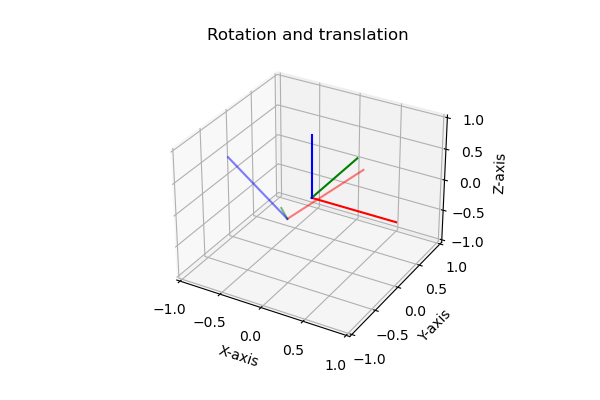

In [31]:
# create figure
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

# set axis limits
ax.set(xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1))

# plot the standard global basis
ax = pr.plot_basis(ax)

# plot the transformed basis
ax = pr.plot_basis(ax, R, alpha=0.5, p=np.array([0, -0.5, 0]))

# set labels
ax.set_title("Rotation and translation")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

Perfect

#### Extrinsic Parameter Matrix

In [44]:
def create_extrinsic_matrix(angles, order, translation):
    '''
    Combine rotation and translation and create an extrinsic camera matrix which
    transforms homogeneous coordinates in world space to euclidean coordinates
    in the camera frame
    '''
    R = create_rotation_matrix_extrinsic(angles, order)
    t = translation.reshape(3, 1)
    return np.hstack((R, t))

In [51]:
# basis in homogeneous coordinates
xh = np.array([1, 0, 0, 1])
yh = np.array([0, 1, 0, 1])
zh = np.array([0, 0, 1, 1])

t = np.array([0, -0.5, 0])

In [52]:
E = create_extrinsic_matrix(angles, order, t)

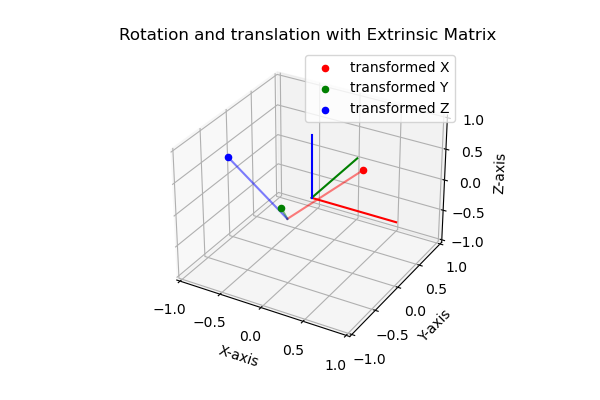

In [56]:
# create figure
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

# set axis limits
ax.set(xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1))

# plot the standard global basis
ax = pr.plot_basis(ax)

# plot the transformed basis
ax = pr.plot_basis(ax, R, alpha=0.5, p=np.array([0, -0.5, 0]))

# validate the extrinsic camera matrix
xt = np.matmul(E, xh.reshape(4, 1))
yt = np.matmul(E, yh.reshape(4, 1))
zt = np.matmul(E, zh.reshape(4, 1))

ax.scatter(*xt, label="transformed X", color="red")
ax.scatter(*yt, label="transformed Y", color="green")
ax.scatter(*zt, label="transformed Z", color="blue")

# set labels
ax.set_title("Rotation and translation with Extrinsic Matrix")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.legend()

Perfect